[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Data Visualizations

## Step 1: Link Notebook to GitHub and Google Drive

In [ ]:
import os
import shutil
from google.colab import drive
from google.colab import files

# Remove Colab default sample_data
!rm -r ./sample_data
#!rm -r ./BrainAgingComputerVision

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 329 (delta 58), reused 76 (delta 29), pack-reused 202
Receiving objects: 100% (329/329), 244.74 MiB | 21.08 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [ ]:
# Connect to Google Drive for full dataset
# place should indicate the folder with the csv file and zipped image_data file
drive.mount('/content/gdrive')
place = '/content/gdrive/My Drive/School/'

Mounted at /content/gdrive


In [ ]:
#move to /content so image manipulation can be done here without using local storage
shutil.copytree(place, '/content/data')

'/content/data'

## Step 2: Import Scripts and Dependencies

In [ ]:
!pip3 install -r "{os.path.join(repo_name,'requirements.txt')}" > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 6.4.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 6.4.1 which is incompatible.


In [ ]:
from BrainAgingComputerVision.scripts.loaders import RegressionLoaders, SingleLoader
from BrainAgingComputerVision.scripts.Rtraining import MakeAndTrain
from BrainAgingComputerVision.scripts.Rpredicting import BatchPredict, SinglePredict

import os
from google.colab import drive
from google.colab import files

#for image processing
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

#for metadata
import pandas as pd

#for data file structure
#import splitfolders
import shutil

#for modeling
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#import torchvision
#from torchvision import datasets, transforms
#from torchvision.datasets import ImageFolder
#from torchvision.transforms import Compose, ToTensor, Resize
#from torch.utils.data import Subset, DataLoader, Dataset
#from sklearn.model_selection import train_test_split
#from torchsummary import summary

#for metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Step 2: Data Visualizations

### A) Initial Images (unzips dataset and continues)

In [ ]:
#pull up image metadata
filein = '/content/data/cn_age_df.csv'
data = pd.read_csv(filein)
#data.head()

In [ ]:
#to reset:
#shutil.rmtree("/content/image_data")

In [ ]:
#import files (1267 files)
#note that naming convention includes "test" and "val" but that is not for this project
#!unzip '/content/data/image_data.zip' > /dev/null
!unzip '/content/BrainAgingComputerVision/data/image_data.zip' > /dev/null

replace 118_A_val.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#select some for demo purposes and zip
#flist = os.listdir('/content/image_data')
#random.shuffle(flist)
#chunk = flist[:10]
#os.mkdir('sub')

#for f in chunk:
  #imgpl1 = "/content/image_data/" + f
  #imgpl2 = "/content/sub/" + f
  #shutil.copyfile(imgpl1, imgpl2) 

#!zip -r /content/image_data.zip /content/sub

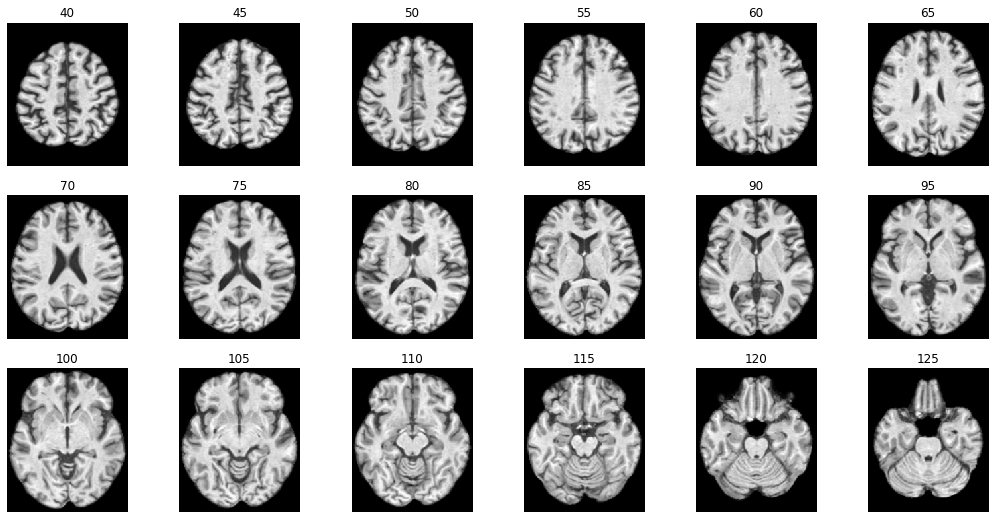

In [ ]:
#pick a 3D image to take a look at
image_path = '/content/118_A_val.npy'
image3D = np.load(image_path)

#show image size (218*182*182)
#print(image3D.size)

#loop to show slices in 5 slice increments
start_sl = 40
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(3, 6)
for m in range(3):
  for w in range(6):
    im = Image.fromarray((image3D[start_sl] * 255).astype(np.uint8))
    im = np.rot90(im)
    axs[m, w].imshow(im, interpolation='nearest', cmap='gray')
    axs[m, w].set_title(str(start_sl))
    axs[m, w].axis('off')
    start_sl += 5

fig.savefig("slices2.png")

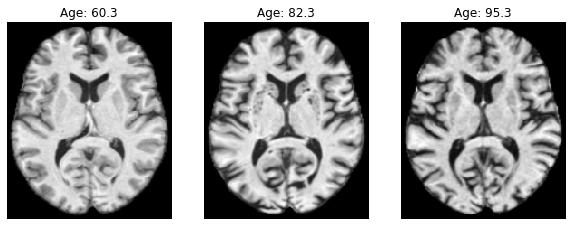

In [ ]:
#display different ages for reference
#60, 82, 94

images = ['/content/image_data/1488_A_train.npy', '/content/image_data/17_N_test.npy', '/content/image_data/41_A_train.npy']

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 3)
i=0
for m in images:
  #get image
  image_3D = np.load(m)
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  name = "example"+str(i)+".npy"
  #np.save(name, im)
  axs[i].imshow(im, interpolation='nearest', cmap='gray')
  #get title
  imgn = m.split("/")[-1]
  imgn = imgn.split(".")[0]
  line = data.loc[data['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[i].set_title("Age: " + str(label))
  axs[i].axis('off')
  i += 1

fig.savefig("3ages.png")


### B) Loader Images (unzips independently)

In [ ]:
#to reset
shutil.rmtree("/content/data/image_data")
shutil.rmtree("/content/data/train")
shutil.rmtree("/content/data/val")

In [ ]:
#this unzips, slices, transforms, and adds files to loaders
train_loader, test_loader = RegressionLoaders('/content/data')

images, labels = iter(train_loader).next()
#print(images.shape)


TypeError: ignored

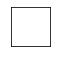

In [ ]:
# Visualize a batch of images 
# note: they were compressed sideways, and yes, ages were recorded to a decimal
fig = plt.figure(figsize=(15, 5))
for idx in range(len(train_loader)):
    ax = fig.add_subplot(2, len(train_loader)//2, idx+1, xticks=[], yticks=[])
    im = np.squeeze(images[idx])
    im = np.rot90(images)
    ax.imshow(im, cmap='gray')
    ax.set_title(labels[idx].tolist())

### C) Model Output - Training

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train the model
model, cost_path = MakeAndTrain(train_loader, device)

# Visualize the loss curve
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Loss: 221.395249


KeyboardInterrupt: ignored

### D) Model Output - Prediction

In [ ]:
#load model and get test predictions
model2 = torch.load('/content/BrainAgingComputerVision/models/model.pt')
preds, labels = BatchPredict(model2, test_loader, device)

Test set MSE: 16.207189493183176
Test set MAE: 3.2343752384185787


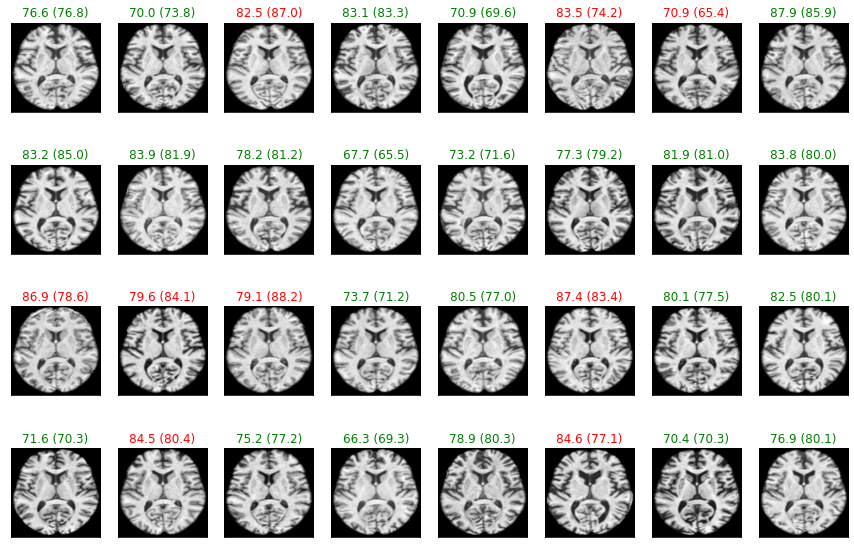

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Test set MSE: '+ str(mean_squared_error(labels,preds)))
print('Test set MAE: '+ str(mean_absolute_error(labels,preds)))

# Function to display a batch of predictions
def visualize_results(preds, labels):

    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        #images
        ax = fig.add_subplot(4, len(preds)//4, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = tf.convert_to_tensor(std) * image + tf.convert_to_tensor(mean)
        image = np.clip(image, 0, 1)
        image = np.squeeze(image)
        image = np.rot90(image)
        ax.imshow(image, cmap='gray')
        #titles
        line = str(preds[idx])+" ("+str(labels[idx])+")"
        ax.set_title(line, color=("green" if abs(preds[idx]-labels[idx])<=4 else "red"))
    return

visualize_results(preds, labels)

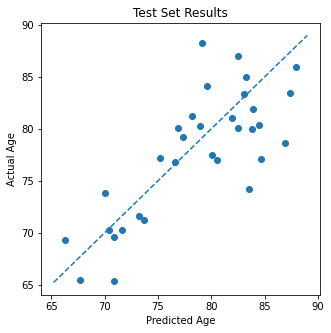

In [ ]:
#scatterplot
fig = plt.figure(figsize=(5, 5))
plt.scatter(preds, labels)
plt.title("Test Set Results")
plt.xlabel("Predicted Age")
plt.ylabel("Actual Age")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--')
#plt.axis('equal')
plt.show()

### Single Prediction

In [ ]:
#%cd /content/BrainAgingComputerVision
#!git pull

img = np.load('/content/BrainAgingComputerVision/data/example0.npy')

image = SingleLoader(img)
pred = SinglePredict(model2, image, device)
print("Pred: "+str(pred))

Pred: 88.7


In [ ]:
images = [f for f in listdir('/content') if isfile(join('/content', f))]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(2, 5)
i=0
for m in range(2):
  for w in range(5):
    #get image
    here = os.path.join('/content/',images[i])
    image_3D = np.load(here)
    im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
    im = np.rot90(im)
    axs[m,w].imshow(im, interpolation='nearest', cmap='gray')
    #get title
    imgn = images[i].split(".")[0]
    line = data.loc[data['Data ID'] == imgn]
    label = line.iloc[0][5]
    axs[m,w].set_title('ID: '+imgn+ ", Age: " + str(label))
    axs[m,w].axis('off')
    i += 1

fig.savefig("examples.png")